## Immothep, les m² en folie

Ce notebook a pour but d'analyser le fichier des "Demandes de valeur foncière" et d'essayer d'en sortir un algorythme d'IA.



In [157]:

# chargement des extensions
%reload_ext autoreload
%autoreload 2

# import des librairies
from modules.data.loader import DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.ensemble import IsolationForest


## 1. Chargement des données

In [145]:
data_loder = DataLoader()
data_loder.ensure_split()

global_dataset = data_loder.get_data('63000')

## 2. Analyse macro du jeu de données

Le but est de regarder la répartition des données et de détecter les première anomalies

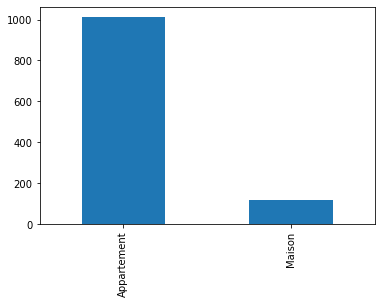

In [146]:
local_dataset = global_dataset.copy()
local_dataset['Type local'].value_counts().plot(kind='bar')

local_dataset = local_dataset[local_dataset['Type local'] == 'Appartement']

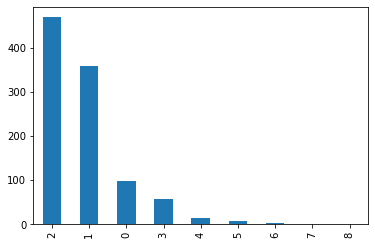

In [147]:
local_dataset['Nombre de lots'].value_counts().plot(kind='bar')

local_dataset = local_dataset[local_dataset['Nombre de lots'] == 1]

 1    324
-1     35
Name: anomaly, dtype: int64
                           Valeur fonciere  ...  anomaly
Valeur fonciere                   1.000000  ...      NaN
Surface reelle bati               0.389228  ...      NaN
Nombre pieces principales         0.311603  ...      NaN
scores                           -0.640923  ...      NaN
anomaly                                NaN  ...      NaN

[5 rows x 5 columns]


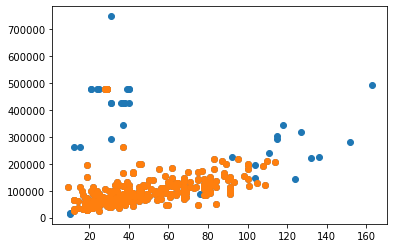

In [174]:
d = local_dataset[['Valeur fonciere', 'Date mutation', 'Surface reelle bati', "Nombre pieces principales"]]

plt.scatter(d['Surface reelle bati'], d['Valeur fonciere'])

model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(d[['Surface reelle bati', 'Valeur fonciere', "Nombre pieces principales"]])

d['scores']=model.decision_function(d[['Surface reelle bati', 'Valeur fonciere', "Nombre pieces principales"]])
d['anomaly']=model.predict(d[['Surface reelle bati', 'Valeur fonciere', "Nombre pieces principales"]])

print(d['anomaly'].value_counts())

t = d[d['anomaly'] == 1]
print(t.corr())

plt.scatter(t['Surface reelle bati'], t['Valeur fonciere'])